in this notebook we:
* stage 4 - rescaled images, but then downscaled only by 2

In [1]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

import wandb
from wandb.fastai import WandbCallback

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import configparser

from functions_wandb import *

In [2]:
%matplotlib inline

In [3]:
wandb.init(project="gabon")

W&B Run: https://app.wandb.ai/jedrzej/gabon/runs/1h0imz54

In [6]:
# PATH_TO_IMG = Path("/data_rescaled")

# PATH_TO_MAIN = Path("/home/jupyter/")
# PATH_TO_TRAIN_DF = PATH_TO_MAIN / "inspect_data_split_validation"
# PATH_TO_MODELS = PATH_TO_MAIN / "training" / "saved_models"
# PATH_TO_CONFIG = PATH_TO_MAIN / "config"

# CONFIG = configparser.ConfigParser()
# CONFIG.read(PATH_TO_CONFIG / "neptune.ini")

In [3]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")

classes = df.species.unique()
print(len(classes)) # no "Mammal_Other"
classes

28


array(['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey',
       'Duiker_Red', 'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [4]:
len(df.uniqueName)

347120

In [5]:
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [6]:
df["uniqueName"] = df.uniqueName.apply(lambda x: "resc_" + x)
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,resc_0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,resc_0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,resc_0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,resc_0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,resc_0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [7]:
%%time
data = get_training_data(df, (384 // 2, 512 // 2), batch_size=128)#, partial_pct=0.01)

CPU times: user 3.95 s, sys: 260 ms, total: 4.21 s
Wall time: 2.59 s


In [8]:
# %%time
# data.show_batch()

# Stage 4

In [9]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage3-1epochs-192_256-rescaled");

In [10]:
learn.unfreeze()

In [11]:
%%time
run_find_lr(learn, "stage4-5epochs-192_256-rescaled")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/opt/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



CPU times: user 18.3 s, sys: 6.82 s, total: 25.1 s
Wall time: 1min 2s


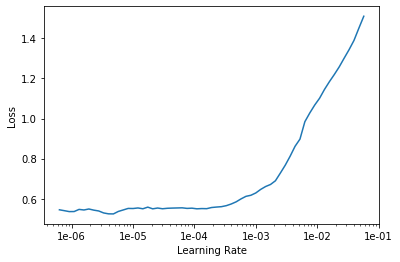

In [12]:
learn.recorder.plot()

In [14]:
initial_lr = 1e-4 * 2
lr = 1e-5
lr_end = initial_lr / 5
n_epochs =  5

In [15]:
%%time
run_training(learn, "stage4-5epochs-192_256-rescaled", lr=lr, lr_end=lr_end, n_epochs=n_epochs)

epoch,train_loss,valid_loss,accuracy,time
0,0.413582,1.299158,0.651096,30:55
1,0.320399,1.304240,0.667713,29:44
2,0.263960,1.313175,0.682199,29:25
3,0.201770,1.320442,0.683644,29:20
4,0.170760,1.325495,0.683483,29:30


Better model found at epoch 0 with valid_loss value: 1.2991578578948975.
Loaded best saved model from /home/jupyter/training/wandb/run-20200312_124616-1h0imz54/bestmodel.pth
CPU times: user 42min 47s, sys: 14min 18s, total: 57min 5s
Wall time: 2h 28min 57s


In [ ]:
learn.recorder.plot_losses()

In [ ]:
fig = learn.recorder.plot_losses(return_fig=True)
fig.savefig("loss_plot-stage4-5epochs-192_256-rescaled.png")

### Load model and investigate results

In [9]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage4-5epochs-192_256-rescaled");

In [12]:
wandb.init(project="gabon")

W&B Run: https://app.wandb.ai/jedrzej/gabon/runs/39mr90sv

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

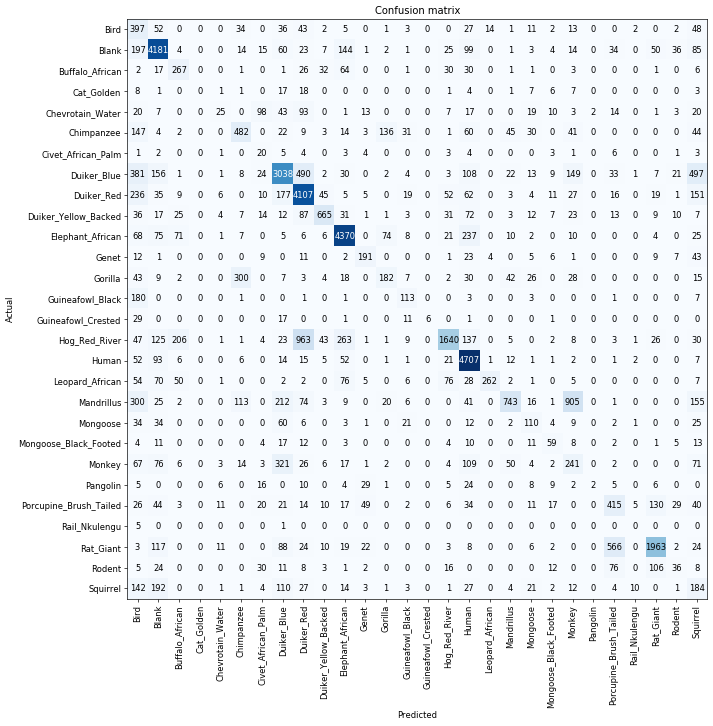

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
conf_m = interp.confusion_matrix()

In [17]:
len(conf_m)

28

In [20]:
correct_p = sum([conf_m[i,i] for i in range(len(conf_m))])
correct_p

28406

In [21]:
all_p = conf_m.sum().sum()
all_p

43628

In [23]:
print(f"accuracy is: {round(100 * correct_p / all_p,2)}%")

accuracy is: 65.11%


Idea: group similar spieces together to get a block matrix - will look much better